This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import ranksums
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

# Preparing the data

## Grabing the CVS data...

In [3]:
variables = ["Area","Separation","Width","Concentration"]
# variables = ["Area","Separation","Width","Concentration","Wavelength","Battery voltage"]

In [4]:
try:
    table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')[['studentid']+variables]
    graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')[['studentid']+variables]
    table_non_cons_df = pd.read_csv('table_non_consecutive_cvs_results_2-3-4.txt', sep='\t')[['studentid']+variables]
except:
    raise Exception("Try running the notebook cvs_detector.ipynb and then run this cell again.")

In [5]:
table_cvs_df.head()

,studentid,Area,Separation,Width,Concentration
0,11612162,0,0,2,3
1,13660166,0,0,0,14
2,41947147,0,0,6,7
3,64006159,0,0,0,6
4,15749160,2,3,4,10


In [6]:
def binarize(threshold,number):
    if number>= threshold : return 1
    else: return 0
    
# Given that we want to compare the stringency of CVS, we created different definitions with 2,3,4 points needed

graph_cvs_2_df = graph_cvs_df.copy()
graph_cvs_3_df = graph_cvs_df.copy()
graph_cvs_4_df = graph_cvs_df.copy()
graph_cvs_5_df = graph_cvs_df.copy()
for v in variables:
    graph_cvs_2_df[v] = graph_cvs_df.apply(lambda row: binarize(2,row[v]), axis=1)
    graph_cvs_3_df[v] = graph_cvs_df.apply(lambda row: binarize(3,row[v]), axis=1)
    graph_cvs_4_df[v] = graph_cvs_df.apply(lambda row: binarize(4,row[v]), axis=1)
    graph_cvs_5_df[v] = graph_cvs_df.apply(lambda row: binarize(5,row[v]), axis=1)

table_cvs_2_df = table_cvs_df.copy()
table_cvs_3_df = table_cvs_df.copy()
table_cvs_4_df = table_cvs_df.copy()
table_cvs_5_df = table_cvs_df.copy()
for v in variables:
    table_cvs_2_df[v] = table_cvs_df.apply(lambda row: binarize(2,row[v]), axis=1)
    table_cvs_3_df[v] = table_cvs_df.apply(lambda row: binarize(3,row[v]), axis=1)
    table_cvs_4_df[v] = table_cvs_df.apply(lambda row: binarize(4,row[v]), axis=1)
    table_cvs_5_df[v] = table_cvs_df.apply(lambda row: binarize(5,row[v]), axis=1)
    
table_non_cons_2_df = table_non_cons_df.copy()
table_non_cons_3_df = table_non_cons_df.copy()
table_non_cons_4_df = table_non_cons_df.copy()
for v in variables:
    table_non_cons_2_df[v] = table_non_cons_df.apply(lambda row: binarize(2,row[v]), axis=1)
    table_non_cons_3_df[v] = table_non_cons_df.apply(lambda row: binarize(3,row[v]), axis=1)
    table_non_cons_4_df[v] = table_non_cons_df.apply(lambda row: binarize(4,row[v]), axis=1)

In [7]:
#Since no one does CVS graph without table, we can this simple addition of the dataframes
cvs_2_df = table_non_cons_2_df.copy();cvs_3_df = table_non_cons_2_df.copy();cvs_4_df = table_non_cons_2_df.copy()
for v in variables:
    cvs_2_df[v] = 2*(table_cvs_2_df[v]+graph_cvs_2_df[v]*2) + table_non_cons_2_df[v]
    cvs_3_df[v] = 2*(table_cvs_3_df[v]+graph_cvs_3_df[v]*2) + table_non_cons_3_df[v]
    cvs_4_df[v] = 2*(table_cvs_4_df[v]+graph_cvs_4_df[v]*2) + table_non_cons_4_df[v]

In [8]:
for df in [cvs_2_df,cvs_3_df,cvs_4_df]:
    df.replace(0,'x',inplace=True)
    df.replace(1,'table_random',inplace=True)
    df.replace(2,'table_consecutive',inplace=True);    df.replace(3,'table_consecutive',inplace=True)
    df.replace(5,'graph',inplace=True);    df.replace(7,'graph',inplace=True)

In [9]:
cvs_2_df.head()

,studentid,Area,Separation,Width,Concentration
0,11612162,x,x,table_consecutive,graph
1,13660166,x,x,x,graph
2,41947147,x,x,graph,graph
3,64006159,table_random,x,table_random,graph
4,15749160,graph,table_consecutive,table_consecutive,table_consecutive


In [10]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
cvs_2_df['activity order'] = cvs_2_df.studentid.apply(lambda sid: order[sid])
cvs_3_df['activity order'] = cvs_3_df.studentid.apply(lambda sid: order[sid])
cvs_4_df['activity order'] = cvs_4_df.studentid.apply(lambda sid: order[sid])

# Analysis

## Descriptives

In [11]:
N = len(set(cvs_2_df['studentid']))
print "The study includes {0} students".format(N)

The study includes 148 students


C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


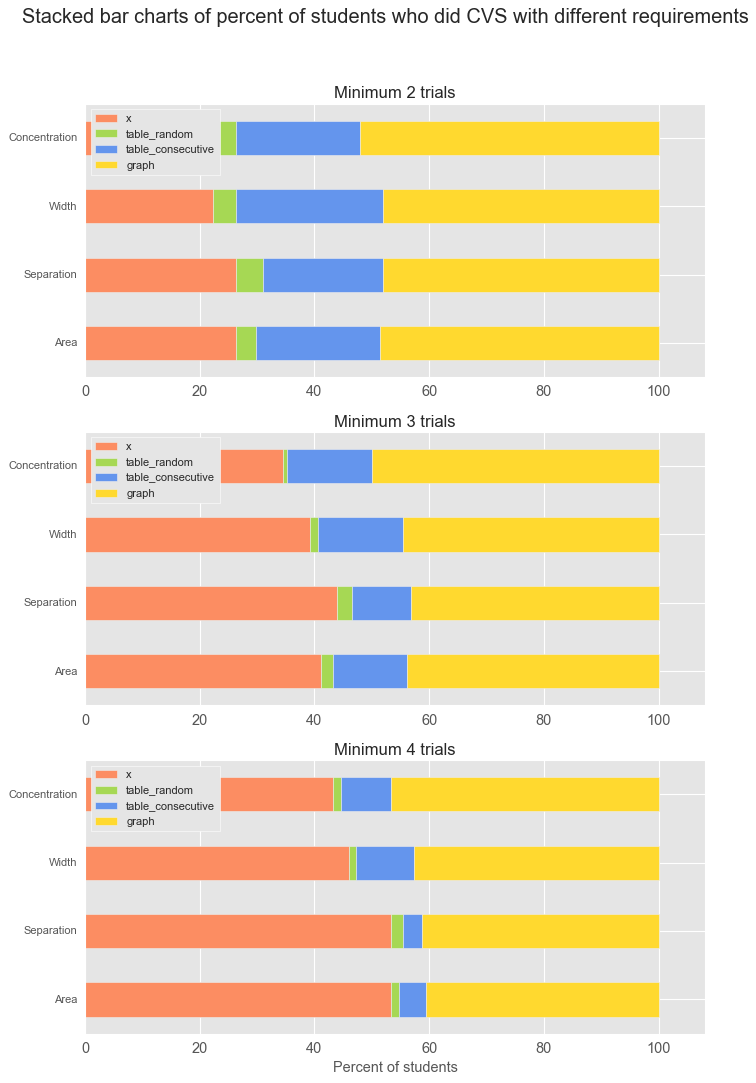

In [12]:
CMAP = ['#fc8d62','#a6d854','cornflowerblue','#ffd92f']
matplotlib.rcParams['axes.color_cycle'] = CMAP
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(10,15))
for ax,X,df in zip(axes,['2','3','4'],[cvs_2_df, cvs_3_df, cvs_4_df]):
    df[variables].apply(lambda x: x.value_counts()).transpose().iloc[:,::-1].plot.barh(stacked=True, ax=ax)
    ax.legend(loc=2,frameon=True);ax.set_xlabel('')
    ax.set_xticklabels([0,20,40,60,80,100],fontsize=13)
    ax.set_xticks([round(int(x)*N/100.0,1) for x in [0,20,40,60,80,100]])
    ax.set_title("Minimum " + X + " trials",fontsize=15);
ax.set_xlabel('Percent of students',fontsize=13)
plt.suptitle("Stacked bar charts of percent of students who did CVS with different requirements",fontsize=18);

In [13]:
avgs = pd.DataFrame()
for X,df in zip(['2','3','4'],[cvs_2_df, cvs_3_df, cvs_4_df]):
    avgs[X] = df[variables].apply(lambda x: x.value_counts()).transpose().iloc[:,::-1].mean(axis=0)

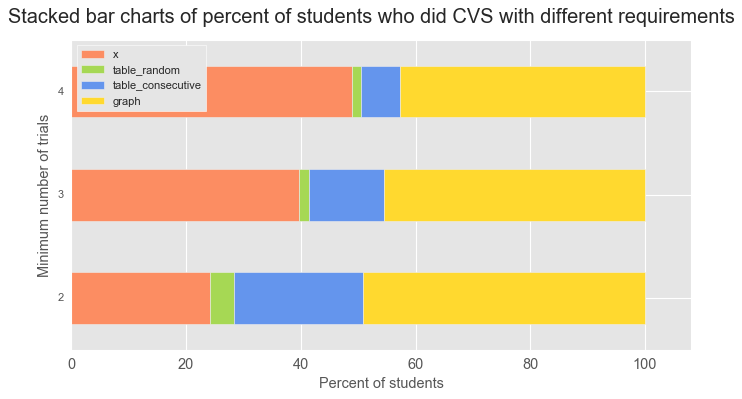

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
avgs.transpose().iloc[:,::1].plot.barh(stacked=True,ax=ax)
ax.legend(loc=2,frameon=True);ax.set_xlabel('')
ax.set_xticklabels([0,20,40,60,80,100],fontsize=13)
ax.set_xticks([round(int(x)*N/100.0,1) for x in [0,20,40,60,80,100]])
ax.set_xlabel('Percent of students',fontsize=13)
ax.set_ylabel('Minimum number of trials',fontsize=13)
plt.suptitle("Stacked bar charts of percent of students who did CVS with different requirements",fontsize=18);

Looks like few students do CVS non consecutively. In fact we can check how many students do it for at least 1 variable:

In [15]:
data = cvs_3_df.copy()
data['x'] = (data[variables]=='x').astype(int).sum(axis=1)
data['table_random'] = (data[variables]=='table_random').astype(int).sum(axis=1)
data['table_consecutive'] = (data[variables]=='table_consecutive').astype(int).sum(axis=1)
data['graph'] = (data[variables]=='graph').astype(int).sum(axis=1)
data.head()

,studentid,Area,Separation,Width,Concentration,activity order,x,table_random,table_consecutive,graph
0,11612162,x,x,x,graph,CL,3,0,0,1
1,13660166,x,x,x,graph,LC,3,0,0,1
2,41947147,x,x,graph,graph,CL,2,0,0,2
3,64006159,x,x,x,graph,LC,3,0,0,1
4,15749160,x,table_consecutive,table_consecutive,table_consecutive,CL,1,0,3,0


In [16]:
len(data[data['studentid'].isin(data[data['table_random']>0]['studentid'])])

9

## Analyze students by CVS usage

In [17]:
cluster_columns = ['x','table_random','table_consecutive','graph']

In [18]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(data[cluster_columns])
pca.explained_variance_ratio_.cumsum()

array([ 0.773,  0.983,  1.   ,  1.   ])

In [19]:
NC = 3
pca = decomposition.PCA(n_components=NC)
pca.fit(data[cluster_columns])
X = pca.transform(data[cluster_columns])
data['PC1'] = zip(*X)[0]
data['PC2'] = zip(*X)[1]
data['PC3'] = zip(*X)[2]

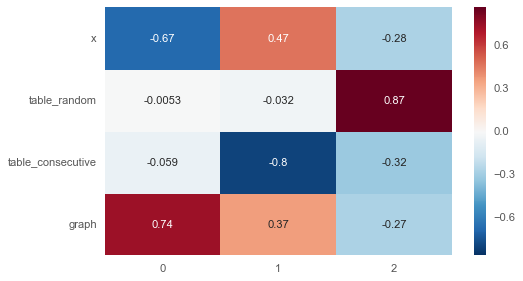

In [20]:
sns.heatmap(pca.components_.T,yticklabels=cluster_columns,annot=True)